link to dataset site: 
https://archive.ics.uci.edu/dataset/936/national+poll+on+healthy+aging+(npha)

# Step 2: Explore the Dataset

In [2]:
import pandas as pd
import numpy as np

filepath = "NPHA-doctor-visits.csv"
df = pd.read_csv(filepath)

df

,Number of Doctors Visited,Age,Phyiscal Health,Mental Health,Dental Health,Employment,Stress Keeps Patient from Sleeping,Medication Keeps Patient from Sleeping,Pain Keeps Patient from Sleeping,Bathroom Needs Keeps Patient from Sleeping,Uknown Keeps Patient from Sleeping,Trouble Sleeping,Prescription Sleep Medication,Race,Gender
0,3,2,4,3,3,3,0,0,0,0,1,2,3,1,2
1,2,2,4,2,3,3,1,0,0,1,0,3,3,1,1
2,3,2,3,2,3,3,0,0,0,0,1,3,3,4,1
3,1,2,3,2,3,3,0,0,0,1,0,3,3,4,2
4,3,2,3,3,3,3,1,0,0,0,0,2,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,2,2,2,2,2,3,0,0,0,1,0,3,3,1,1
710,3,2,2,2,2,2,1,0,0,0,1,2,3,1,2
711,3,2,4,2,3,3,0,0,0,0,0,3,3,1,1
712,3,2,3,1,3,3,1,0,1,1,1,3,3,1,2


## Step 2.1

In [5]:
gender_subgroups = df["Gender"].value_counts().sort_index()
race_subgroups = df["Race"].value_counts().sort_index()
age_values = df["Age"].value_counts().sort_index()

print(f'Gender subgroups: {gender_subgroups}\n')
print(f'Race subgroups: {race_subgroups}\n')
# print(f'Age range:\nMin Age {age_values.min()}\nMax Age: {age_values.max()}')
print(F'Age Groups: {age_values}')

Gender subgroups: Gender
1    321
2    393
Name: count, dtype: int64

Race subgroups: Race
1    578
2     52
3     20
4     44
5     20
Name: count, dtype: int64

Age Groups: Age
2    714
Name: count, dtype: int64


## 2.2

In [ ]:
gender_mapping = {1: "Male", 2: "Female"}
race_mapping = {
    1: "White, non-Hispanic",
    2: "Black, non-Hispanic",
    3: "Other, non-Hispanic",
    4: "Hispanic",
    5: "2+ Races, Non-Hispanic"
}
age_mapping = {
    1: "50-64",
    2: "65-80"
}

## 2.4

In [10]:
gender_doctors_table = pd.crosstab(df["Gender"], df["Number of Doctors Visited"])
print("Gender vs. Number of Doctors Visited")
print(gender_doctors_table)


Gender vs. Number of Doctors Visited
Number of Doctors Visited   1    2    3
Gender                                 
1                          56  173   92
2                          75  199  119


In [15]:
gender_meds_table = pd.crosstab(df["Gender"], df["Prescription Sleep Medication"])
print("\nGender vs. Prescription Sleep Medication")
print(gender_meds_table)



Gender vs. Prescription Sleep Medication
Prescription Sleep Medication  -1   1   2    3
Gender                                        
1                               0  21  15  285
2                               3  17  19  354


In [20]:
race_doctors_table = pd.crosstab(df["Race"], df["Number of Doctors Visited"])
print("\nRace vs. Number of Doctors Visited")
print(race_doctors_table)



Race vs. Number of Doctors Visited
Number of Doctors Visited    1    2    3
Race                                    
1                          103  296  179
2                            8   32   12
3                            7    6    7
4                           13   24    7
5                            0   14    6


In [25]:
race_meds_table = pd.crosstab(df["Race"], df["Prescription Sleep Medication"])
print("\nRace vs. Prescription Sleep Medication")
print(race_meds_table)



Race vs. Prescription Sleep Medication
Prescription Sleep Medication  -1   1   2    3
Race                                          
1                               2  31  31  514
2                               1   3   0   48
3                               0   1   0   19
4                               0   2   2   40
5                               0   1   1   18


## 2.5

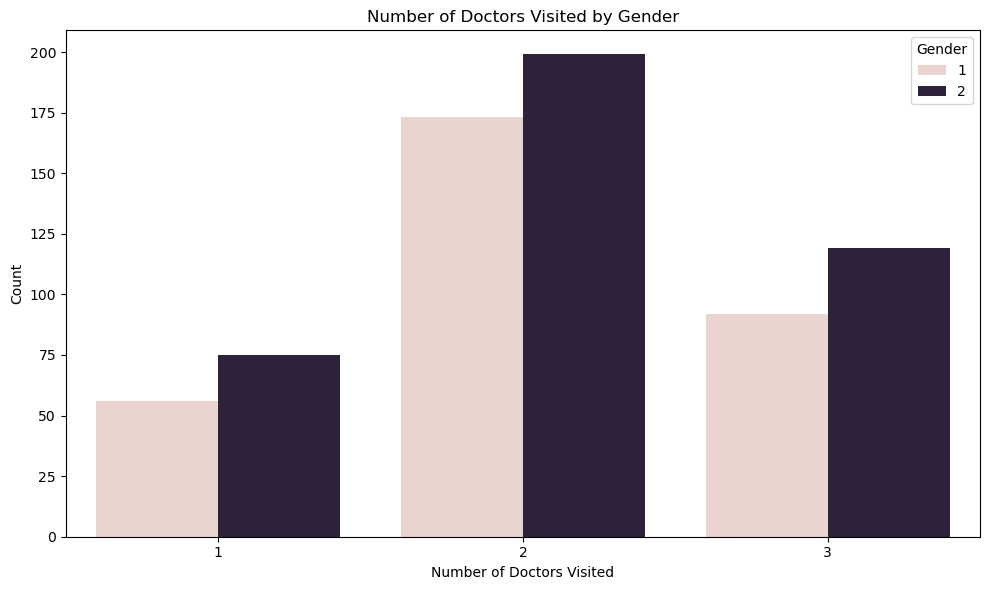

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gender vs Doctors Visited
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Number of Doctors Visited", hue="Gender")
plt.xlabel("Number of Doctors Visited")
plt.title("Number of Doctors Visited by Gender")
plt.ylabel("Count")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()


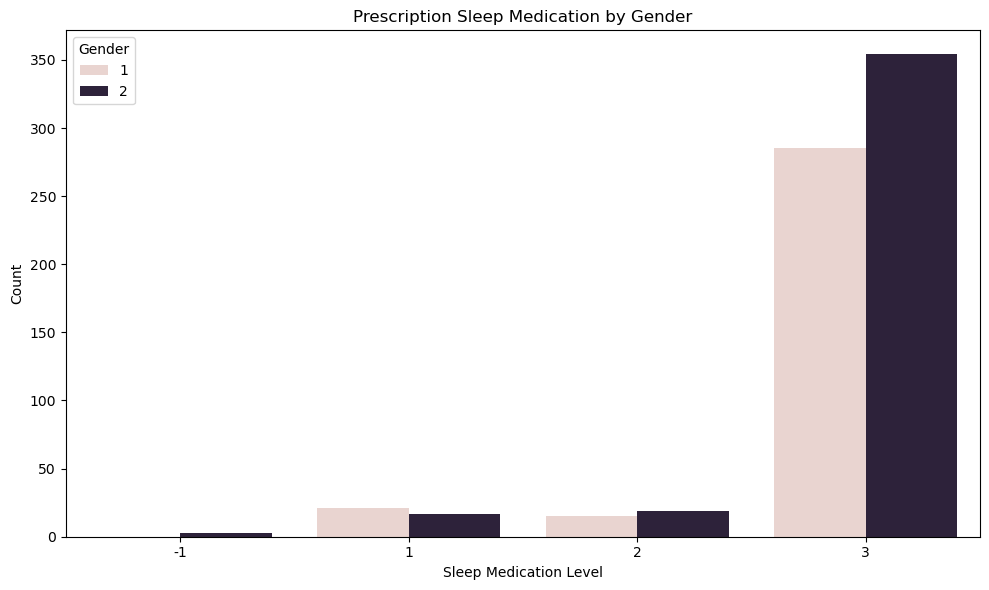

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Prescription Sleep Medication", hue="Gender")
plt.xlabel("Sleep Medication Level")
plt.ylabel("Count")
plt.title("Prescription Sleep Medication by Gender")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()


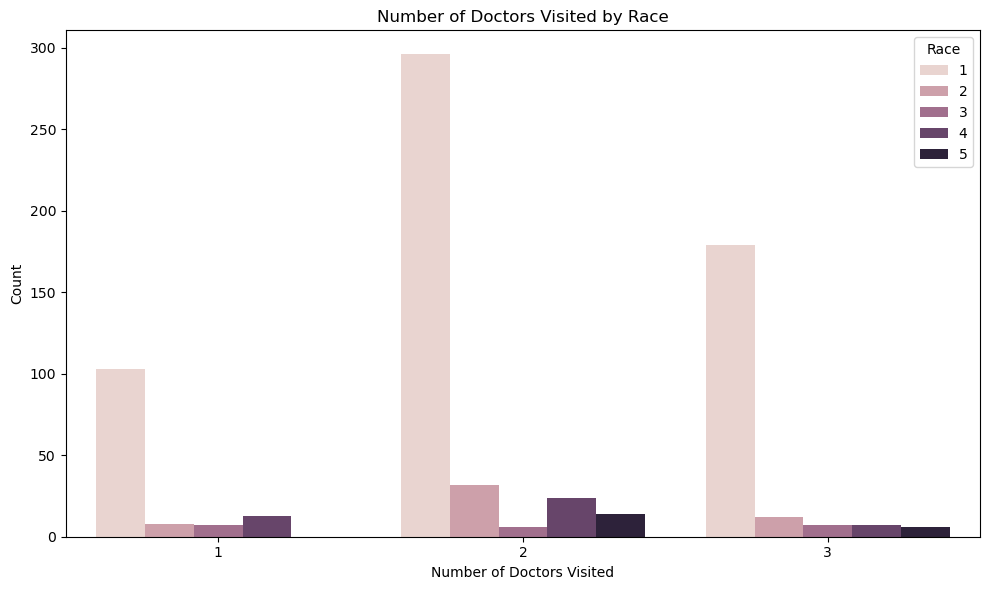

In [30]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Number of Doctors Visited", hue="Race")
plt.title("Number of Doctors Visited by Race")
plt.ylabel("Count")
plt.legend(title="Race")
plt.xlabel("Number of Doctors Visited")
plt.tight_layout()
plt.show()


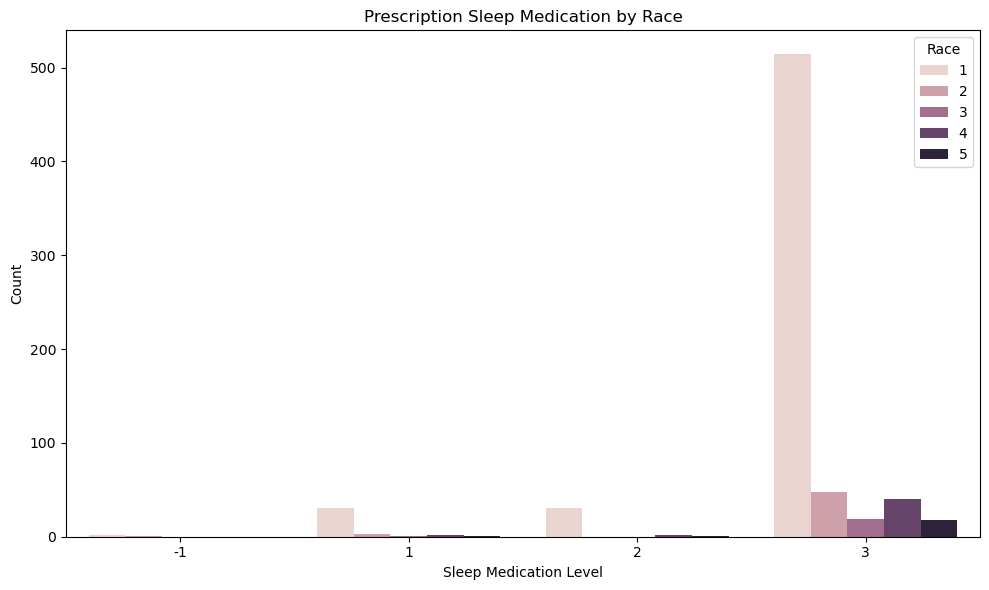

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Prescription Sleep Medication", hue="Race")
plt.title("Prescription Sleep Medication by Race")
plt.ylabel("Count")
plt.legend(title="Race")
plt.xlabel("Sleep Medication Level")
plt.tight_layout()
plt.show()
